In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [1]:
import pandas as pd

import awswrangler as wr
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

sns.set_theme()

import itertools 
import matplotlib.gridspec as gridspec

from matplotlib.dates import DayLocator, HourLocator, DateFormatter, drange

import warnings
warnings.filterwarnings('ignore')

from tsai.all import *

from pywaffle import Waffle

In [2]:
# read in ai & video status csv
df = pd.read_pickle('../data/integration_state_evaluations_videocopy_ai.pickle')

In [3]:
df.head()

,original_path,decrypted_datetime,start_datetime,status,videocopy_no_video,videocopy_found_unable_to_copy,videocopy_late,videocopy_ok,ai_vidok_but_did_not_try,ai_crash_no_output,ai_outputed_but_cant_parse,ai_crash_output_too_fast,ai_ok
0,/thalos/brancol/videos/cam1/14-02-2024/13/14-02-2024-13-20.avi.done,2024-02-14 13:29:33.704918+00:00,2024-02-14 13:20:00+00:00,done,False,False,False,True,False,False,False,False,True
1,/thalos/brancol/videos/cam1/14-02-2024/13/14-02-2024-13-25.avi.done,2024-02-14 13:34:46.711594+00:00,2024-02-14 13:25:00+00:00,done,False,False,False,True,False,False,False,False,True
2,/thalos/brancol/videos/cam1/14-02-2024/13/14-02-2024-13-30.avi.done,2024-02-14 13:39:59.714153+00:00,2024-02-14 13:30:00+00:00,done,False,False,False,True,False,False,False,False,True
3,/thalos/brancol/videos/cam1/14-02-2024/13/14-02-2024-13-35.avi.done,2024-02-14 13:45:12.632197+00:00,2024-02-14 13:35:00+00:00,done,False,False,False,True,False,False,False,False,True
4,/thalos/brancol/videos/cam1/14-02-2024/13/14-02-2024-13-40.avi.done,2024-02-14 13:50:25.577168+00:00,2024-02-14 13:40:00+00:00,done,False,False,False,True,False,False,False,False,True


In [4]:
len(df)

28145

In [43]:
report_colors = sns.color_palette(['#184EAD','#648fff','#88ccee','#ae9ef7','#6844d5','#332288','#c52dac','#ef4341','#84164c','#cb6577','#ff6100','#90550f','#c78d1b','#ffb003','#ddcc77','#a2c662','#40a018','#117347','#43aa99'])

color_list = ['#184EAD','#648fff','#88ccee','#ae9ef7','#6844d5','#332288','#c52dac','#ef4341','#84164c','#cb6577','#ff6100','#90550f','#c78d1b','#ffb003','#ddcc77','#a2c662','#40a018','#117347','#43aa99']

%matplotlib inline
color_list = ['#184EAD','#648fff','#88ccee','#ae9ef7','#6844d5','#332288','#c52dac','#ef4341','#84164c','#cb6577','#ff6100','#90550f','#c78d1b','#ffb003','#ddcc77','#a2c662','#40a018','#117347','#43aa99']
def show_color_pallete(pallete):
# fig, ax = plt.subplots()
    
    sns.palplot(pallete, size=2)
    ax = plt.gca()
    for i, name in enumerate(pallete):
        label = f'[{i}]'
        ax.text(i, -.57, label,horizontalalignment='center', fontsize = 10) 
    plt.show()

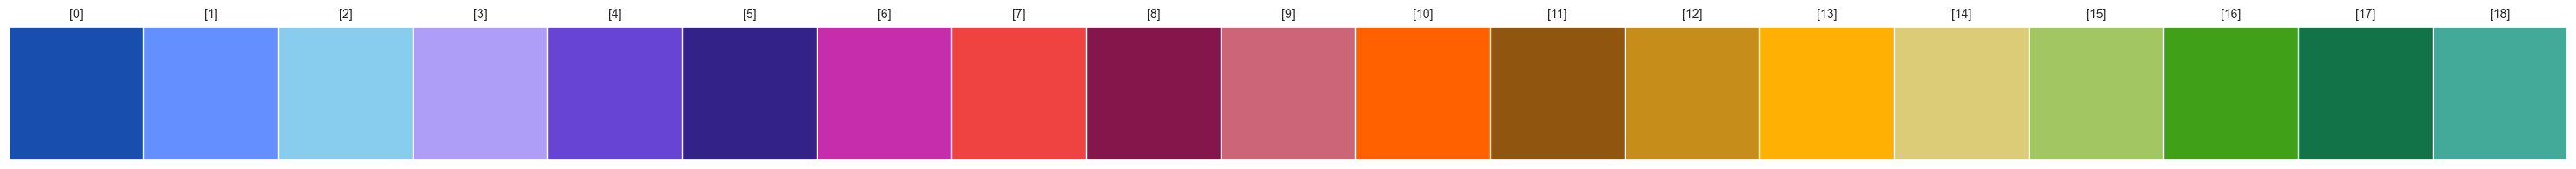

In [44]:
show_color_pallete(report_colors)

In [19]:
#create a dictionary of statuses and values
video_cols = ['videocopy_no_video', 'videocopy_found_unable_to_copy','videocopy_late', 'videocopy_ok']
ai_cols = ['ai_vidok_but_did_not_try','ai_crash_no_output', 'ai_outputed_but_cant_parse','ai_crash_output_too_fast', 'ai_ok']
video_status = {}
ai_status = {}
for video_col in video_cols:
    value_counts = df[video_col].value_counts().to_dict()
    if True in value_counts.keys():
        video_status[video_col] = {'value': value_counts[True]}


for ai_col in ai_cols:
    value_counts = df[ai_col].value_counts().to_dict()
    # print(value_counts)
    if True in value_counts.keys():
        ai_status[ai_col] = {'value': value_counts[True]}


ai_status['no_video'] = {'value': video_status['videocopy_no_video']['value']+ video_status['videocopy_found_unable_to_copy']['value']}

print(video_status)
print(ai_status)
# print(statusDF['status'].value_counts().to_dict())
print(' ')


{'videocopy_no_video': {'value': 7693}, 'videocopy_found_unable_to_copy': {'value': 242}, 'videocopy_late': {'value': 286}, 'videocopy_ok': {'value': 19924}}
{'ai_vidok_but_did_not_try': {'value': 110}, 'ai_crash_no_output': {'value': 1706}, 'ai_outputed_but_cant_parse': {'value': 39}, 'ai_crash_output_too_fast': {'value': 4024}, 'ai_ok': {'value': 14279}, 'no_video': {'value': 7935}}
 


In [34]:
# dictionaries of column name and desired display label and color for ai status
ai_dict = {
    'no_video': {
        'label': 'No Video',
        'color':'#949494' 
    },
    'ai_vidok_but_did_not_try': {
        'label': 'Video ok but did not try',
        'color':report_colors[1]
    } ,
    'ai_crash_no_output': {
        'label': 'Crash, no output',
        'color': report_colors[10]
    }, 
    'ai_outputed_but_cant_parse': {
        'label': 'Outputted, cannot parse',
        'color':report_colors[13]
    },
    'ai_crash_output_too_fast': {
        'label': 'Empty Output',
        'color':report_colors[6]
    },
       'ai_ok': {
           'label': 'Ok',
           'color': report_colors[15]
    }
}

video_dict = {
    'videocopy_no_video': {
        'label': 'No Video',
        'color': '#949494'
    },
    'videocopy_found_unable_to_copy': {
        'label': 'Video found, unable to copy',
        'color': report_colors[10]
    } ,
    'videocopy_late': {
        'label': 'Late',
        'color':report_colors[13]
    }, 
    'videocopy_ok': {
        'label': 'Ok',
        'color': report_colors[15]
    },
}

In [39]:
# update ai_status dict with the colors and labels from ai_dict
for key, value in ai_dict.items():
    ai_status[key].update(value)

for key, value in video_dict.items():
    video_status[key].update(value)

In [36]:
## Manual Entry of GPS status data
# brancol_gps
# len 67052
# out of disk space error 4377
# num of int errors 355
# num of int errors at power on/off boundary 639
# num of ok  61681

# saintpatrick_gps
# len 71367
# num of int errors 842
# num of int errors at power on/off boundary 908
# num of ok  69617

# totals
gps_len = 67052 + 71367
out_of_disk_space = 4377
int_errs = 355 + 842
int_errs_pwr = 639 + 908
ok = 61681 + 69617

In [37]:
gps_status = {
    'integration_errors': {
        'value':int_errs,
        'label': 'Integration error',
        'color': report_colors[10]
    },
    'int_errs_pwr': {
        'value':int_errs_pwr,
        'label': 'Integration error at power boundary',
        'color': report_colors[13]
    } ,
    'out_of_disk_space': {
        'value':out_of_disk_space,
        'label': 'Out of disk space',
        'color': report_colors[5]
    }, 
    'gps_ok': {
        'value':ok,
        'label': 'Ok',
        'color': report_colors[15]
    }
}

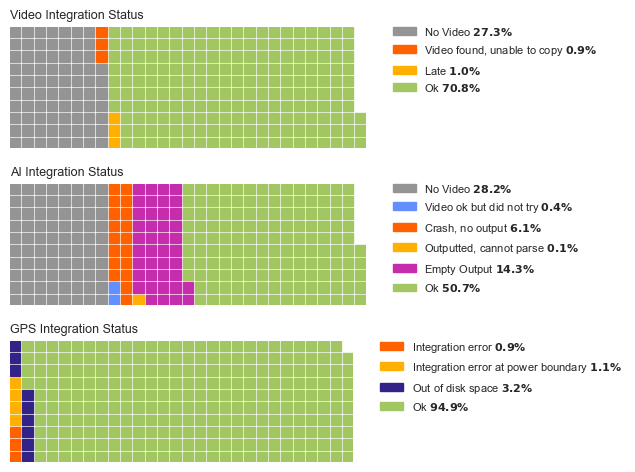

In [42]:
video_col_order = ['videocopy_no_video', 'videocopy_found_unable_to_copy','videocopy_late', 'videocopy_ok']
ai_col_order = ['no_video', 'ai_vidok_but_did_not_try','ai_crash_no_output', 'ai_outputed_but_cant_parse','ai_crash_output_too_fast', 'ai_ok']
gps_order = ['integration_errors', 'int_errs_pwr','out_of_disk_space', 'gps_ok']

waffle_dict = {}

# video status waffle
scale = 100
values = []
labels = []
colors = []
plot_dict = {}


for col in video_col_order: 
    
    value = video_status[col]['value']
    color = video_status[col]['color']
    label = video_status[col]['label'] 
    n = 1

    percent = (value/len(df))*100
    percent_formatted = f"{percent:.1f}\\%"
    formatted_label = label + r' $\bf{{{}}}$'.format(percent_formatted.replace(' ', r'\;'))
    
    values.append(value/scale)
    labels.append(formatted_label)
    colors.append(color)

plot_dict['values'] = values
plot_dict['labels'] = labels
plot_dict['legend'] = {'loc': 'upper left', 'bbox_to_anchor': (1.05, 1.1), 'fontsize': 8, 'frameon':False}
plot_dict['title'] = {'label': "Video Integration Status", 'loc': 'left', 'fontsize': 9}
plot_dict['colors'] = colors

waffle_dict[310+n] = plot_dict
        
# ai status waffle
values = []
labels = []
colors = []
plot_dict = {}

for col in ai_col_order:
    
    label = ai_status[col]['label']
    color = ai_status[col]['color']
    value = ai_status[col]['value']
    n = 2
    
    percent = (value/len(df))*100
    percent_formatted = f"{percent:.1f}\\%"
    formatted_label = label + r' $\bf{{{}}}$'.format(percent_formatted.replace(' ', r'\;'))
    
    values.append(value/scale)
    labels.append(formatted_label)
    colors.append(color)

plot_dict['values'] = values
plot_dict['labels'] = labels
plot_dict['legend'] = {'loc': 'upper left', 'bbox_to_anchor': (1.05, 1.1), 'fontsize': 8, 'frameon':False}
plot_dict['title'] = {'label': "AI Integration Status", 'loc': 'left', 'fontsize': 9}
plot_dict['colors'] = colors

waffle_dict[310+n] = plot_dict


# gps status waffle

scale = 500
values = []
labels = []
plot_dict = {}
colors =[]

for col in gps_order: 
    value = gps_status[col]['value']
    label = gps_status[col]['label']
    color = gps_status[col]['color']
    n = 1

    percent = (value/gps_len)*100
    percent_formatted = f"{percent:.1f}\\%"
    formatted_label = label + r' $\bf{{{}}}$'.format(percent_formatted.replace(' ', r'\;'))
    
    values.append(value/scale)
    labels.append(formatted_label)
    colors.append(color)

plot_dict['values'] = values
plot_dict['labels'] = labels
plot_dict['legend'] = {'loc': 'upper left', 'bbox_to_anchor': (1.05, 1.1), 'fontsize': 8, 'frameon':False}
plot_dict['title'] = {'label': "GPS Integration Status", 'loc': 'left', 'fontsize': 9}
plot_dict['colors'] = colors

waffle_dict[313] = plot_dict



fig = plt.figure(
    FigureClass=Waffle,
    plots=waffle_dict,
    rows=10, # Outside parameter
    # cmap_name="", # Change color with cmap
    rounding_rule='ceil', # Change rounding rule, so value less than 1000 will still have at least 1 block
    figsize=(8, 4.89)
)
# fig.supxlabel(f'1 block = {scale} instances, Each instance occurs at a 5 minute interval',
#               fontsize=10,
#               ha = 'left',
#               x=0, # position at the 14% axis
#              )
# Display the chart

plt.savefig('ai_video_status.png', bbox_inches='tight')